In [1]:
from tensorflow import keras
import keras.layers as layers
from keras.utils import to_categorical
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input,LeakyReLU,Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy, binary_crossentropy
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import chain
import ast

In [2]:
def m2():
  model = Sequential()
     # Flatten layer 
  #model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(120, activation = 'relu', input_shape=(40,)))

  model.add(Dense(60, activation = 'relu'))
  
  # The output layer  
  model.add(Dense(1, activation = 'sigmoid'))

  opt = SGD(learning_rate=0.02)
  model.compile(loss = binary_crossentropy,
                optimizer = opt, 
                metrics = ['accuracy']) 
  
  return model

m2_instance = m2()

In [25]:
training_data_m2 = pd.read_csv('training_data_m2.csv')
#training_data_m2.to_csv('training_data_m2.csv', index=False)
training_data_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   img last conv layer       1526 non-null   object
 1   argument before fc layer  1526 non-null   object
 2   m1 pred                   1526 non-null   int64 
 3   label                     1526 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 47.8+ KB


In [7]:
argument_float = []
for string_data in training_data_m2['argument before fc layer']:
    string_data = string_data.replace("[", "").replace("]", "").replace("\r\n", "").strip()
    values = string_data.split()
    float_values = [float(value) for value in values]
    argument_float.append(float_values)

training_data_m2['argument'] = argument_float
training_data_m2 = training_data_m2.drop(['argument before fc layer', 'img last conv layer', 'm1 pred'], axis = 1)
    


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(training_data_m2['argument'], 
                                                    training_data_m2['label'],
                                                    train_size=0.8
                                                    )


In [9]:
batch_size = 32

def data_generator(data, labels):
    for inn, label in zip(data, labels):
        yield np.array(inn), [label]

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, Y_train),
    output_signature=(
        tf.TensorSpec(shape=(40,), dtype=tf.float32),
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
).batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, Y_test),
    output_signature=(
        tf.TensorSpec(shape=(40,), dtype=tf.float32),
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
).batch(batch_size)

In [63]:
sample_data, sample_label = next(iter(train_dataset))

# Check the shape of the sample data and label
print("Sample data shape:", sample_data.shape)
print("Sample label shape:", sample_label.shape)



Sample data shape: (32, 40)
Sample label shape: (32, 1)


In [11]:

history = m2_instance.fit(
    train_dataset,
    epochs = 50,
    validation_data = test_dataset
    )


Epoch 1/50


39/39 [==============================] - 2s 45ms/step - loss: 0.2622 - accuracy: 0.8836 - val_loss: 0.2204 - val_accuracy: 0.8856
Epoch 2/50
39/39 [==============================] - 0s 6ms/step - loss: 0.1469 - accuracy: 0.9418 - val_loss: 0.1694 - val_accuracy: 0.9477
Epoch 3/50
39/39 [==============================] - 0s 6ms/step - loss: 0.1175 - accuracy: 0.9648 - val_loss: 0.1512 - val_accuracy: 0.9542
Epoch 4/50
39/39 [==============================] - 0s 6ms/step - loss: 0.1054 - accuracy: 0.9639 - val_loss: 0.1442 - val_accuracy: 0.9608
Epoch 5/50
39/39 [==============================] - 0s 6ms/step - loss: 0.0996 - accuracy: 0.9648 - val_loss: 0.1414 - val_accuracy: 0.9575
Epoch 6/50
39/39 [==============================] - 0s 6ms/step - loss: 0.0965 - accuracy: 0.9656 - val_loss: 0.1402 - val_accuracy: 0.9575
Epoch 7/50
39/39 [==============================] - 0s 6ms/step - loss: 0.0946 - accuracy: 0.9656 - val_loss: 0.1397 - val_accuracy: 0.9575
Epoch 8/50
39/39 [============

In [60]:

prediction = m2_instance.predict(test_dataset)
binary_predictions = (prediction > 0.5).astype(int)


10/10 [==============================] - 0s 11ms/step


Text(70.72222222222221, 0.5, 'True classes')

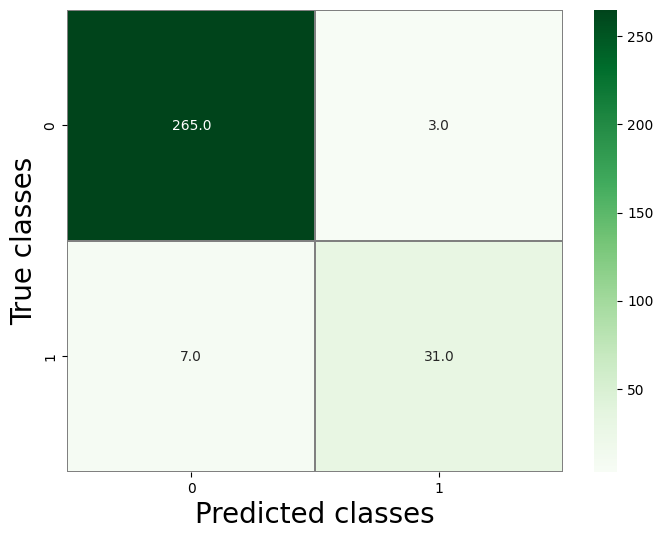

In [61]:
con_mat = confusion_matrix(Y_test, binary_predictions)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)